In [1]:
import sys
sys.path.insert(0,"..")
from queuerious_detector.visuals_eda import *
import pandas as pd
from langdetect import detect

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

In [2]:
#load the data
raw_data = pd.read_csv(
    "../data/raw/aa_dataset-tickets-multi-lang-5-2-50-version.csv")

#view target varible and sample of text data
print(raw_data['queue'].unique())
raw_data[["subject","body"]].sample(2)

['Technical Support' 'Returns and Exchanges' 'Billing and Payments'
 'Sales and Pre-Sales' 'Service Outages and Maintenance' 'Product Support'
 'IT Support' 'Customer Service' 'Human Resources' 'General Inquiry']


,subject,body
22446,Support Request: Performance Issues,"The team has faced performance challenges with the project management SaaS. High traffic on AR-Brille and RapidMiner could be contributing to these issues. Restarting the system and clearing the cache may help improve the situation. However, a deeper investigation is required."
203,Koordinationsherausforderungen zwischen Abteilungen,"Sehr geehrtes Support-Team,\n\nich möchte auf die anhaltenden Schwierigkeiten bei der Abstimmung der Arbeitsprozesse verschiedener Abteilungen, insbesondere im Bereich Strategie, Kreativ und Analytics, hinweisen. Kürzlich wurden erhebliche Verzögerungen entdeckt, die vermutlich auf die Komplexität bei der Integration diverser Workflow-Tools zurückzuführen sind. Zudem besteht die Herausforderung, die Teamkommunikation effizient an einem zentralen Punkt zu bündeln.\n\nTrotz unserer Bemühungen, die aktuellen Abläufe zu überprüfen und die Frequenz der Teammeetings zu erhöhen, bestehen die Probleme weiterhin und beeinträchtigen die Gesamtproduktivität sowie die Projektzeitpläne. Wir vermuten, dass die Ursachen in der mangelnden Kompatibilität und Synchronisierung der genutzten Systeme liegen."


From a previous notebook, I learned that the dataset contains mislabeled languages. I'll use langdetect package to correctly idenitfy the languages and keep only english records. We decided to focus on English tickets for this analysis because translation is resource-intensive

In [3]:
#combine subject + body into a single text field
raw_data["analysis_text"] = raw_data["subject"].fillna('') + " " + raw_data["body"].fillna('')

#use langdetect to find the true language
raw_data["detected_language"] = raw_data["analysis_text"].apply(lambda x: detect(x))

# Only keep English tickets for analysis
english_data = raw_data[raw_data['detected_language'] == 'en']

#### 1. Class Distribution Analysis
 - Queue Distribution: Bar Chart showing frequency of each queue
    - A check of imbalance
- Priority vs. Queue Crosstab: Heatmap of Priority Level by queue
    - Are high priority tickets more prevelant in certain queues


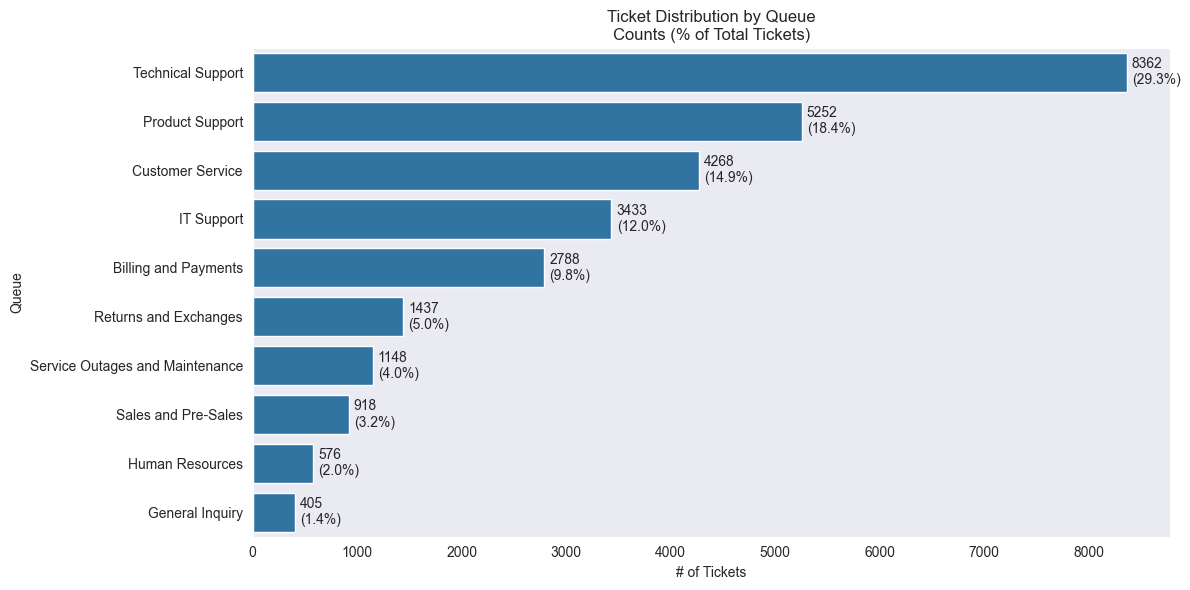

In [4]:
# Plot the distribution of tickets by queue
plot_distribution_with_table(df=raw_data, 
                             x='Tickets', # just a label, not a DataFrame column
                             y='queue', 
                             title="Ticket Distribution by Queue\nCounts (% of Total Tickets)")

Technical Support and IT Support dominate ticket volume; they combine for more than 40% of all tickets. This could be reflective of complex products, frequent bugs, resource gaps, inefficient internal processes, or infrastructure issues. This may also be a place where automation is most valuable. General Inquiry is possibly a catch-all queue when agents are unsure where to assign a ticket.

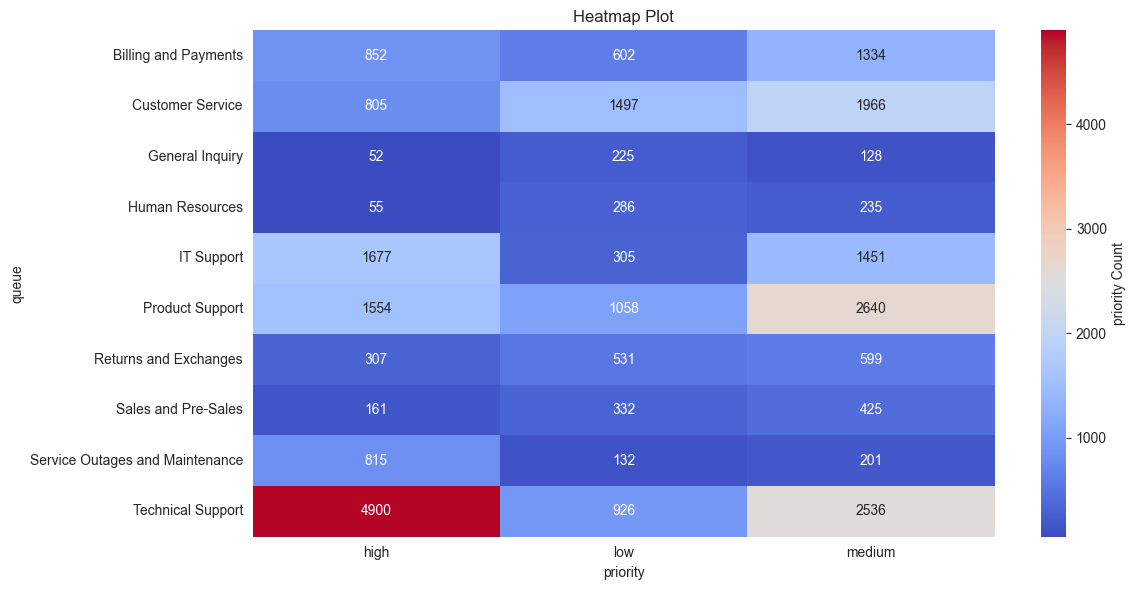

In [5]:
#let's look at the distribution of priority levels across queues
plot_queue_heatmap(raw_data, x='priority', y='queue')

The majority of Technical & IT Support tickets are `high` priority tickets with an additional 3.9k `medium` tickets. Is this queue experiencing outages, bugs, or other issues that are disrupting the business? Customer, Billing & Returns are primarily `medium` tickets while Service Outages and Maintenance is dominated by `high` tickets, which is expected behavior. I'm curious how much the following queues overlap:
- Technical Support, IT Support
- Customer Service, Returns & Exchanges, Billing & Payments

#### 2. Text Feature Exploration
 - Subject & Body Length: Are longer emails in certain queues?
    - Histogram of word counts per queue
- Top Keywords: What words or phrases are common for each queue
    - Table showing most common words or phrases

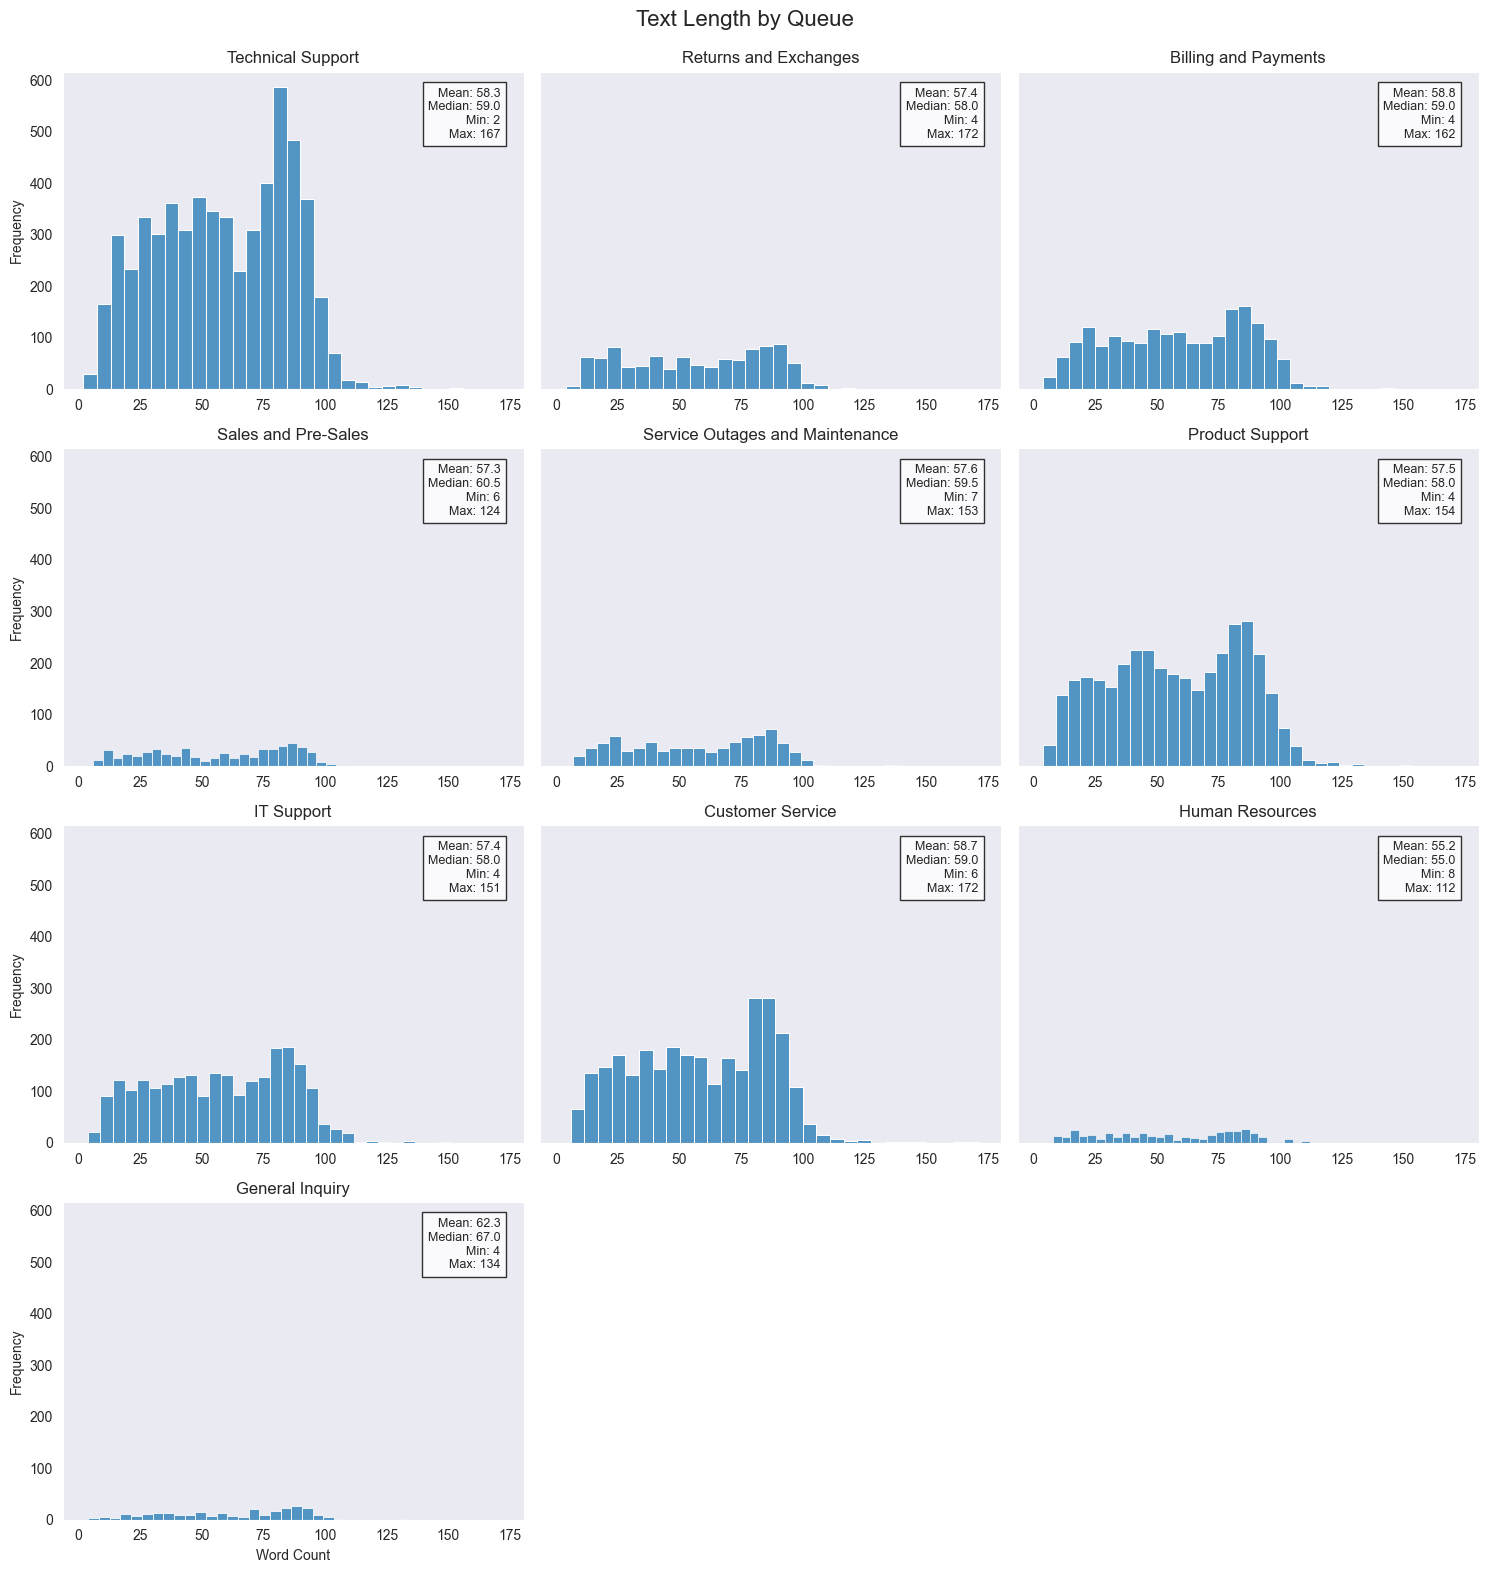

In [6]:
# Plot text length for each queue
plot_text_length_by_queue(english_data, text_col='analysis_text', 
                          queue_col='queue', title='Text Length by Queue\n')

Regarding `Technical Support` and `IT Support`: Both queues have nearly identical average lengths, with only a slight difference of ~1 word in mean and median. Technical Support shows a slightly longer tail (Max: 167 vs. 151) and wider distribution. Min values (2 and 4) suggest occasional very short tickets, possibly system-generated or incomplete. While the averages are close, `Technical Support` shows more variability and longer extremes, indicating that users may submit more detailed or complex technical descriptions compared to the more standardized nature of `IT Support` requests.

Regarding `Customer Service`, `Billing & Payments`, and `Returns & Exchanges`: All three queues show almost identical mean and median word counts, centered just under 59 words. All three share very long outliers (max values ≥ 162), indicating that even routine support categories can sometimes result in detailed messages. Despite serving different functions, these queues attract similarly verbose customer messages.

In [7]:
queues = english_data['queue'].unique().tolist()
top_words = top_keywords_per_queue(english_data, 
                                   text_col='subject', 
                                   queue_col='queue', 
                                   method='count', 
                                   top_n=20,
                                   compare_queues= queues,
                                   visualize=False,
                                   )
# Group by word and count the number of unique queues each word appears in
word_queue_counts = top_words.groupby('word')['queue'].nunique()

# Filter for words that appear in at least 3 queues
common_words = word_queue_counts[word_queue_counts >= 3].index.tolist()

# Display result
display(common_words)

['analytics',
 'assistance',
 'brand',
 'breach',
 'data',
 'digital',
 'inquiry',
 'integration',
 'investment',
 'issue',
 'issues',
 'management',
 'marketing',
 'medical',
 'performance',
 'problem',
 'project',
 'request',
 'saas',
 'security',
 'software',
 'strategies',
 'support',
 'tools']

Using CountVectorizer will help us determine which terms can be added to extend our stop words list. Terms that appear across many queues do not offer discriminatory power (helps the model distinguish between queues). These words are prime candidates for stopword removal because they appear broadly and evenly across support domains, reducing their value for classification.

Term frequency-inverse document frequency assigns weights to words that are specific to a queue. This technique helps understand what makes the queue language distinct. Words that appear too frequently have less weight than words that are unique, rare, or informative. 

For example: ***My analytics dashboard isn't updating the integration feed from our marketing automation tool.***

The terms: `analytics`, `dashboard`, and `integration` help the support agent understand what this specific ticket is about.

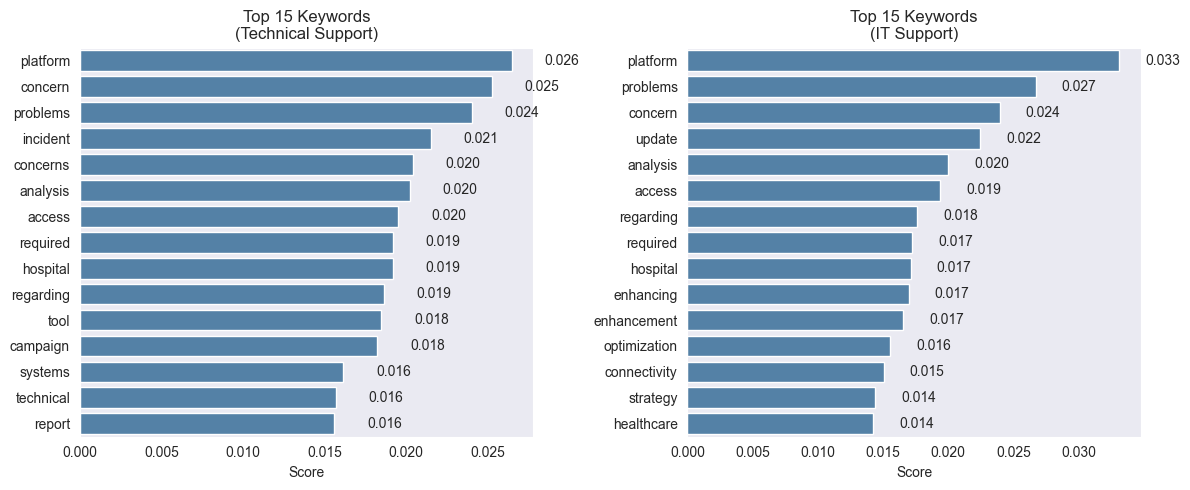

In [8]:
#let's review technical support and IT support keywords usig tfif
top_words = top_keywords_per_queue(english_data, 
                                   text_col='subject', 
                                   queue_col='queue', 
                                   method='tfidf', 
                                   top_n=15,
                                   compare_queues=["Technical Support",
                                                   "IT Support"],
                                   visualize=True,
                                   extra_stopwords=common_words
                                   )

The `Technical Support` and `IT Support` queues share 13/15 keywords and similar text lengths. These queues will be combined.

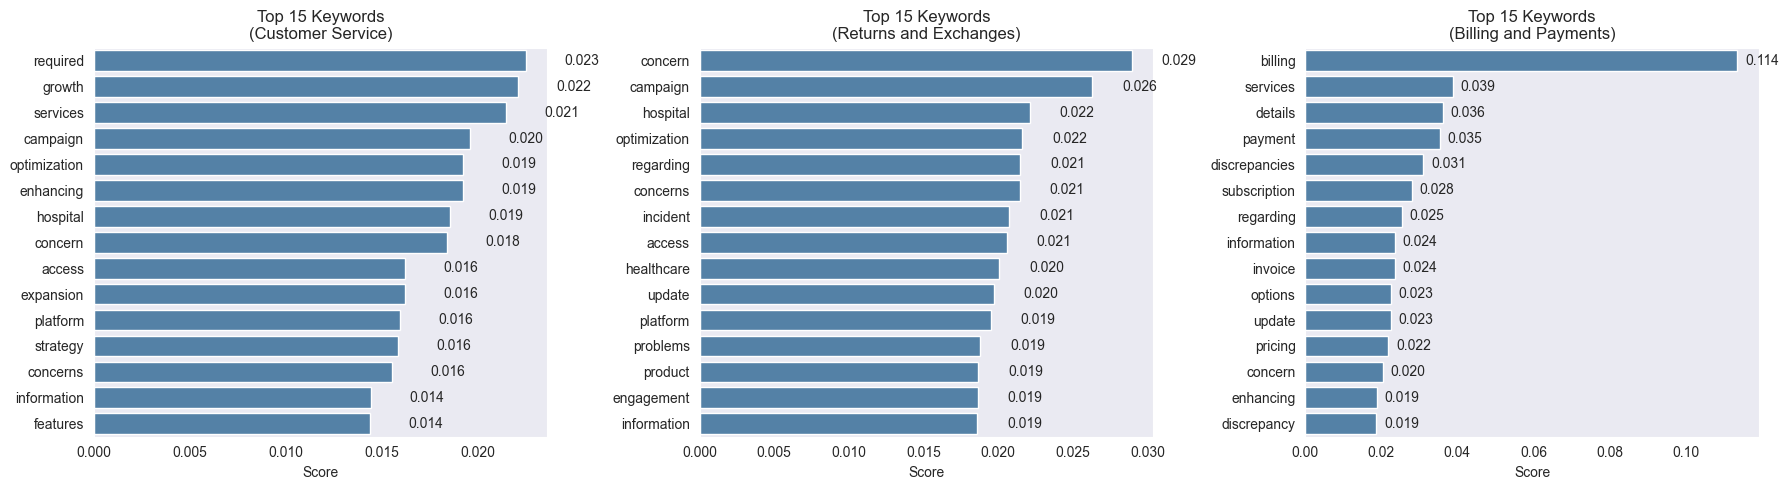

In [9]:
#let's review customer support keywords usig tfif
top_words = top_keywords_per_queue(english_data, 
                                   text_col='subject', 
                                   queue_col='queue', 
                                   method='tfidf', 
                                   top_n=15,
                                   compare_queues=["Customer Service",
                                                   "Returns and Exchanges",
                                                   "Billing and Payments"],
                                   visualize=True,
                                   extra_stopwords=common_words
                                   )

The `Returns and Exchanges` and `Customer Service` queues share many keywords, such as recurring keywords like `campaign`, `platform`, `optimization`, and `concern`. In contrast, the `Billing and Payments` queue stands out with specialized terms like billing, payment, and invoice, indicating a distinct set of issues. So we'll keep the `Billing and Payments` separate, but combine the other two queues.

In [10]:
#combine queues based on the analysis
english_data = english_data.copy()
english_data.loc[:, 'updated_queue'] = english_data['queue'].replace({
    'Technical Support': 'Technical & IT Support',
    'IT Support': 'Technical & IT Support',
    'Customer Service': 'Customer Service, Returns & Exchanges',
    'Returns and Exchanges': 'Customer Service, Returns & Exchanges'
})

#### 3. Ticket Type and Business Type Patterns
 - Type Frequency by Queue: 
    - Are incidents more common in “Technical Support” while “Requests” are in “HR”?
    - Heatmap to check if certain types fall heavily into specific queues.

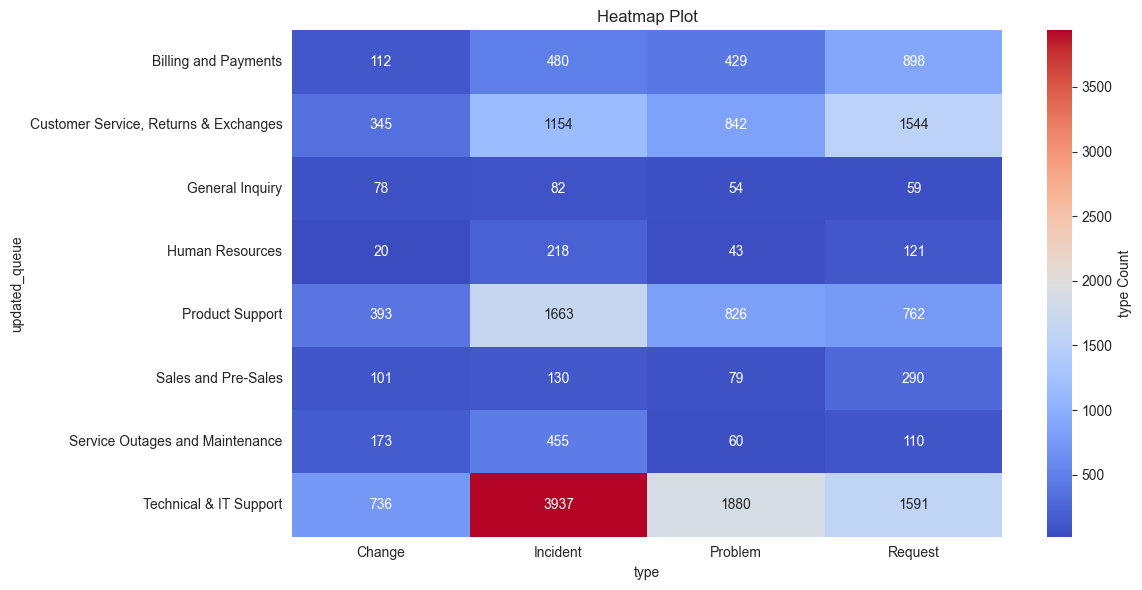

In [11]:
plot_queue_heatmap(english_data, x='type', y='updated_queue')

Incident and Problem tickets are heavily concentrated in the technical & IT support queue. This could mean that the tickets in this queue are related to issues with things not functioning correctly or breaking. Product support tickets are primarily incident and problem types, which means that issues reported are often tied to specific products after the sale. This is insightful, and we can use this as evidence for why the company should assign more agents to the `Technical & IT Support` and `Product Support` queues.